# A4 Classification of Hand-Drawn Digits

In this assignment, you will define a new class named `NeuralNetworkClassifier` that extends the `NeuralNetwork` class provided here and is the solution to Assignment A2.  You will use `NeuralNetworkClassifier` to train a classifier of hand-drawn digits.

You will also define the function `confusion_matrix`.

## `NeuralNetwork` class

In [74]:
import matplotlib.pyplot as plt

The following code cell will write its contents to `optimizers.py` so the `import optimizers` statement in the code cell after it will work correctly.

In [75]:
%%writefile optimizers.py
import numpy as np

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing m, v, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1
        self.beta2t = 1

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    plt.ion()

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin],
                  n_epochs=500, learning_rate=0.1)

    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin],
                   n_epochs=500, learning_rate=0.1)
    
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

Overwriting optimizers.py


In [76]:
import numpy as np
import optimizers
import sys  # for sys.float_info.epsilon

######################################################################
## class NeuralNetwork()
######################################################################

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        if len(self.Tstds) == 1:
            error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar
        else:
            error_convert_f = lambda err: np.sqrt(err)[0] # to scalar
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = Ys[-1]
        # Unstandardize output Y before returning it
        return Y * self.Tstds + self.Tmeans

Adam: Epoch 25 Error=0.26479
Adam: Epoch 50 Error=0.23282
Adam: Epoch 75 Error=0.21048
Adam: Epoch 100 Error=0.18348
Adam: Epoch 125 Error=0.14808
Adam: Epoch 150 Error=0.10748
Adam: Epoch 175 Error=0.07692
Adam: Epoch 200 Error=0.06023
Adam: Epoch 225 Error=0.05070
Adam: Epoch 250 Error=0.04471


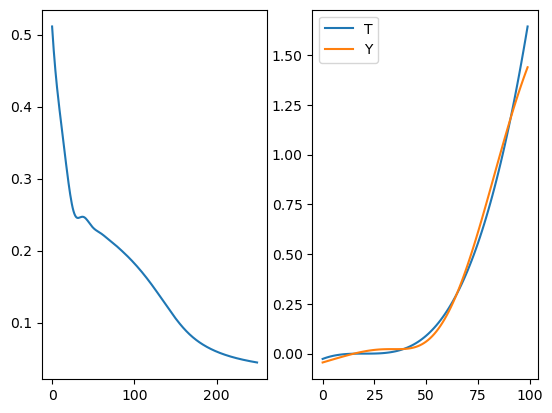

In [77]:
X = np.arange(100).reshape((-1, 1))
T = (X - 20) ** 3 / 300000

hiddens = [10]
nnet = NeuralNetwork(X.shape[1], hiddens, T.shape[1])
nnet.train(X, T, 250, 0.01, method='adam')

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)

plt.subplot(1, 2, 2)
plt.plot(T, label='T')
plt.plot(nnet.use(X), label='Y')
plt.legend()

## Your `NeuralNetworkClassifier` class

Complete the following definition of `NeuralNetworkClassifier` as discussed in class. You will need to override the functions

* `train`
* `error_f`
* `gradient_f`
* `use`

and define the following new functions

* `makeIndicatorVars`
* `softmax`

In [78]:
class NeuralNetworkClassifier(NeuralNetwork):

    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        probs = self.softmax(Ys[-1])
        LL = T*np.log(probs + sys.float_info.epsilon)
        neg_mean_LL = -np.mean(LL)

       # mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return neg_mean_LL

     # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = (T - self.softmax(self.Ys[-1]))
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = -error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        self.classes = np.unique(T)
        T=self.makeIndicatorVars(T)
       
        def error_convert_f(neg_mean_LL):
            return np.exp(-neg_mean_LL)
        
#         if len(self.Tstds) == 1:
#             error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar
#         else:
#             error_convert_f = lambda err: np.sqrt(err)[0] # to scalar


        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)
      
        else:
            raise Exception("method must be 'sgd' or 'adam'")

        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = self.softmax(Ys[-1]) # Ys[-1]
        classes = self.classes[np.argmax(Y, axis=1)].reshape(-1, 1)
        return classes,Y
        
    def softmax(self, Y):
        """Compute softmax values for each sets of scores in x."""
        Y1 = np.exp(Y)
        den = np.sum(Y1,axis=1).reshape((-1,1))
        Y2=Y1/den
        return Y2 #e_x / e_x.sum()


    def makeIndicatorVars(self,T):
        # Make sure T is two-dimensiona. Should be nSamples x 1.
        if T.ndim == 1:
            T = T.reshape((-1,1))    
        return (T == np.unique(T)).astype(int)

Here is a simple test of your new class.  For inputs from 0 to 100, classify values less than or equal to 25 as Class Label 25, greater than 25 and less than or equal to 75 as Class Label 75, and greater than 75 as Class Label 100. 

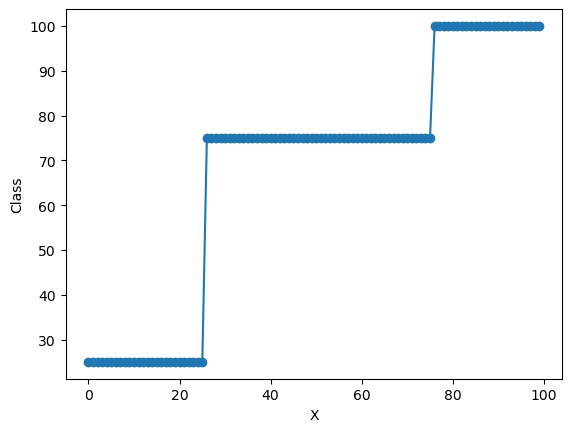

In [79]:
X = np.arange(100).reshape((-1, 1))
T = X.copy()
T[T <= 25] = 25
T[np.logical_and(25 < T, T <= 75)] = 75
T[T > 75] = 100

plt.plot(X, T, 'o-')
plt.xlabel('X')
plt.ylabel('Class');

Adam: Epoch 20 Error=0.76454
Adam: Epoch 40 Error=0.84657
Adam: Epoch 60 Error=0.90537
Adam: Epoch 80 Error=0.93499
Adam: Epoch 100 Error=0.94972
Adam: Epoch 120 Error=0.95823
Adam: Epoch 140 Error=0.96383
Adam: Epoch 160 Error=0.96788
Adam: Epoch 180 Error=0.97096
Adam: Epoch 200 Error=0.97342


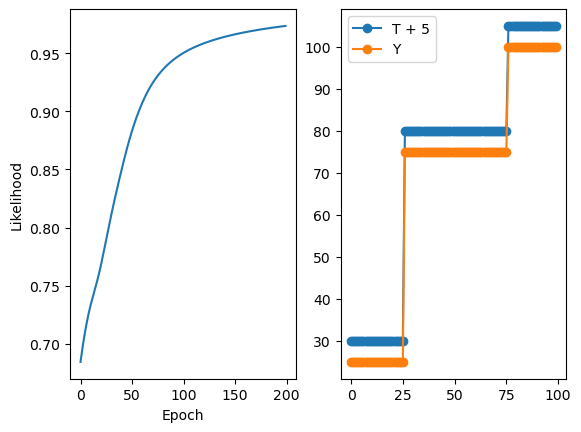

In [80]:
hiddens = [10]
nnet = NeuralNetworkClassifier(X.shape[1], hiddens, len(np.unique(T)))
nnet.train(X, T, 200, 0.01, method='adam', verbose=True)

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T + 5, 'o-', label='T + 5')  # to see, when predicted overlap T very closely
plt.plot(nnet.use(X)[0], 'o-', label='Y')
plt.legend()

## Now for the Hand-Drawn Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz`. 

deeplearning.net goes down a lot.  If you can't download it from there you can try getting it from [here](https://gitlab.cs.washington.edu/colinxs/neural_nets/blob/master/mnist.pkl.gz).

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [81]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [82]:
Ttrain[:10]

array([[5],
       [0],
       [4],
       [1],
       [9],
       [2],
       [1],
       [3],
       [1],
       [4]])

Those must be the digits.  What the heck is in those 784 columns in the input matrices?

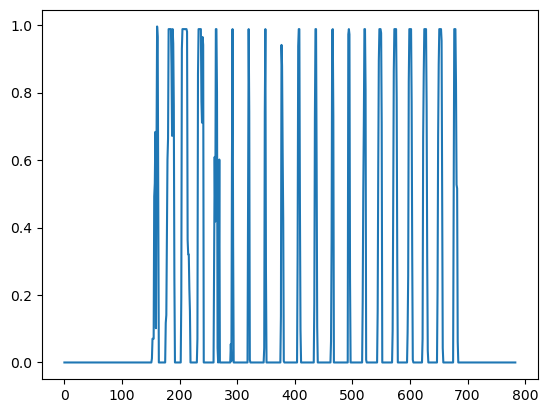

In [83]:
plt.plot(Xtrain[0, :]);

Well, values between 0 and 1.  That doesn't help much.  These are actually intensity values for 784 pixels in an image.

How can we rearrange these values into an image to be displayed?  We must first figure out how many columns and rows the image would have.  Perhaps the image is a square image, with equal numbers of rows and columns.

In [84]:
import math
math.sqrt(784)

28.0

Ah, cool.

In [85]:
28 * 28

784

Ok Let's reshape it and look at the numbers.

In [86]:
image0 = Xtrain[0, :]
image0 = image0.reshape(28, 28)
image0

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

Not that helpful.  Ok, let's use `matplotlib` to make an image display.

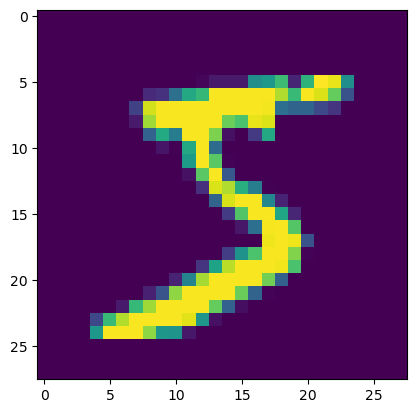

In [87]:
plt.imshow(image0);

Humm.  Try a grayscale color map.

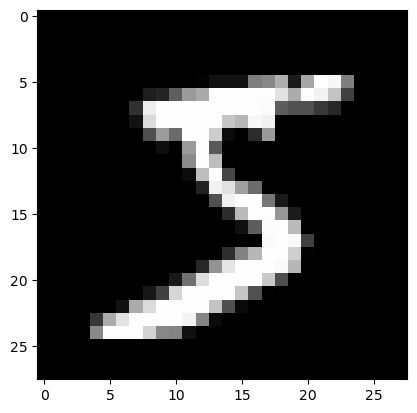

In [88]:
plt.imshow(image0, cmap='gray');

With a little more work, we can make it look like a pencil drawing.

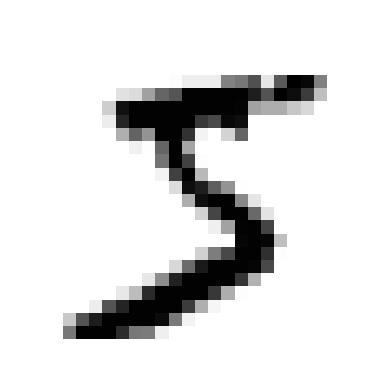

In [89]:
plt.imshow(-image0, cmap='gray')  # notice the negative sign
plt.axis('off');

Looks like a 5.  What class label is associated with this image?

In [90]:
Ttrain[0]

array([5])

Okay.  Makes sense.  Let's look at the first 100 images and their labels, as plot titles.

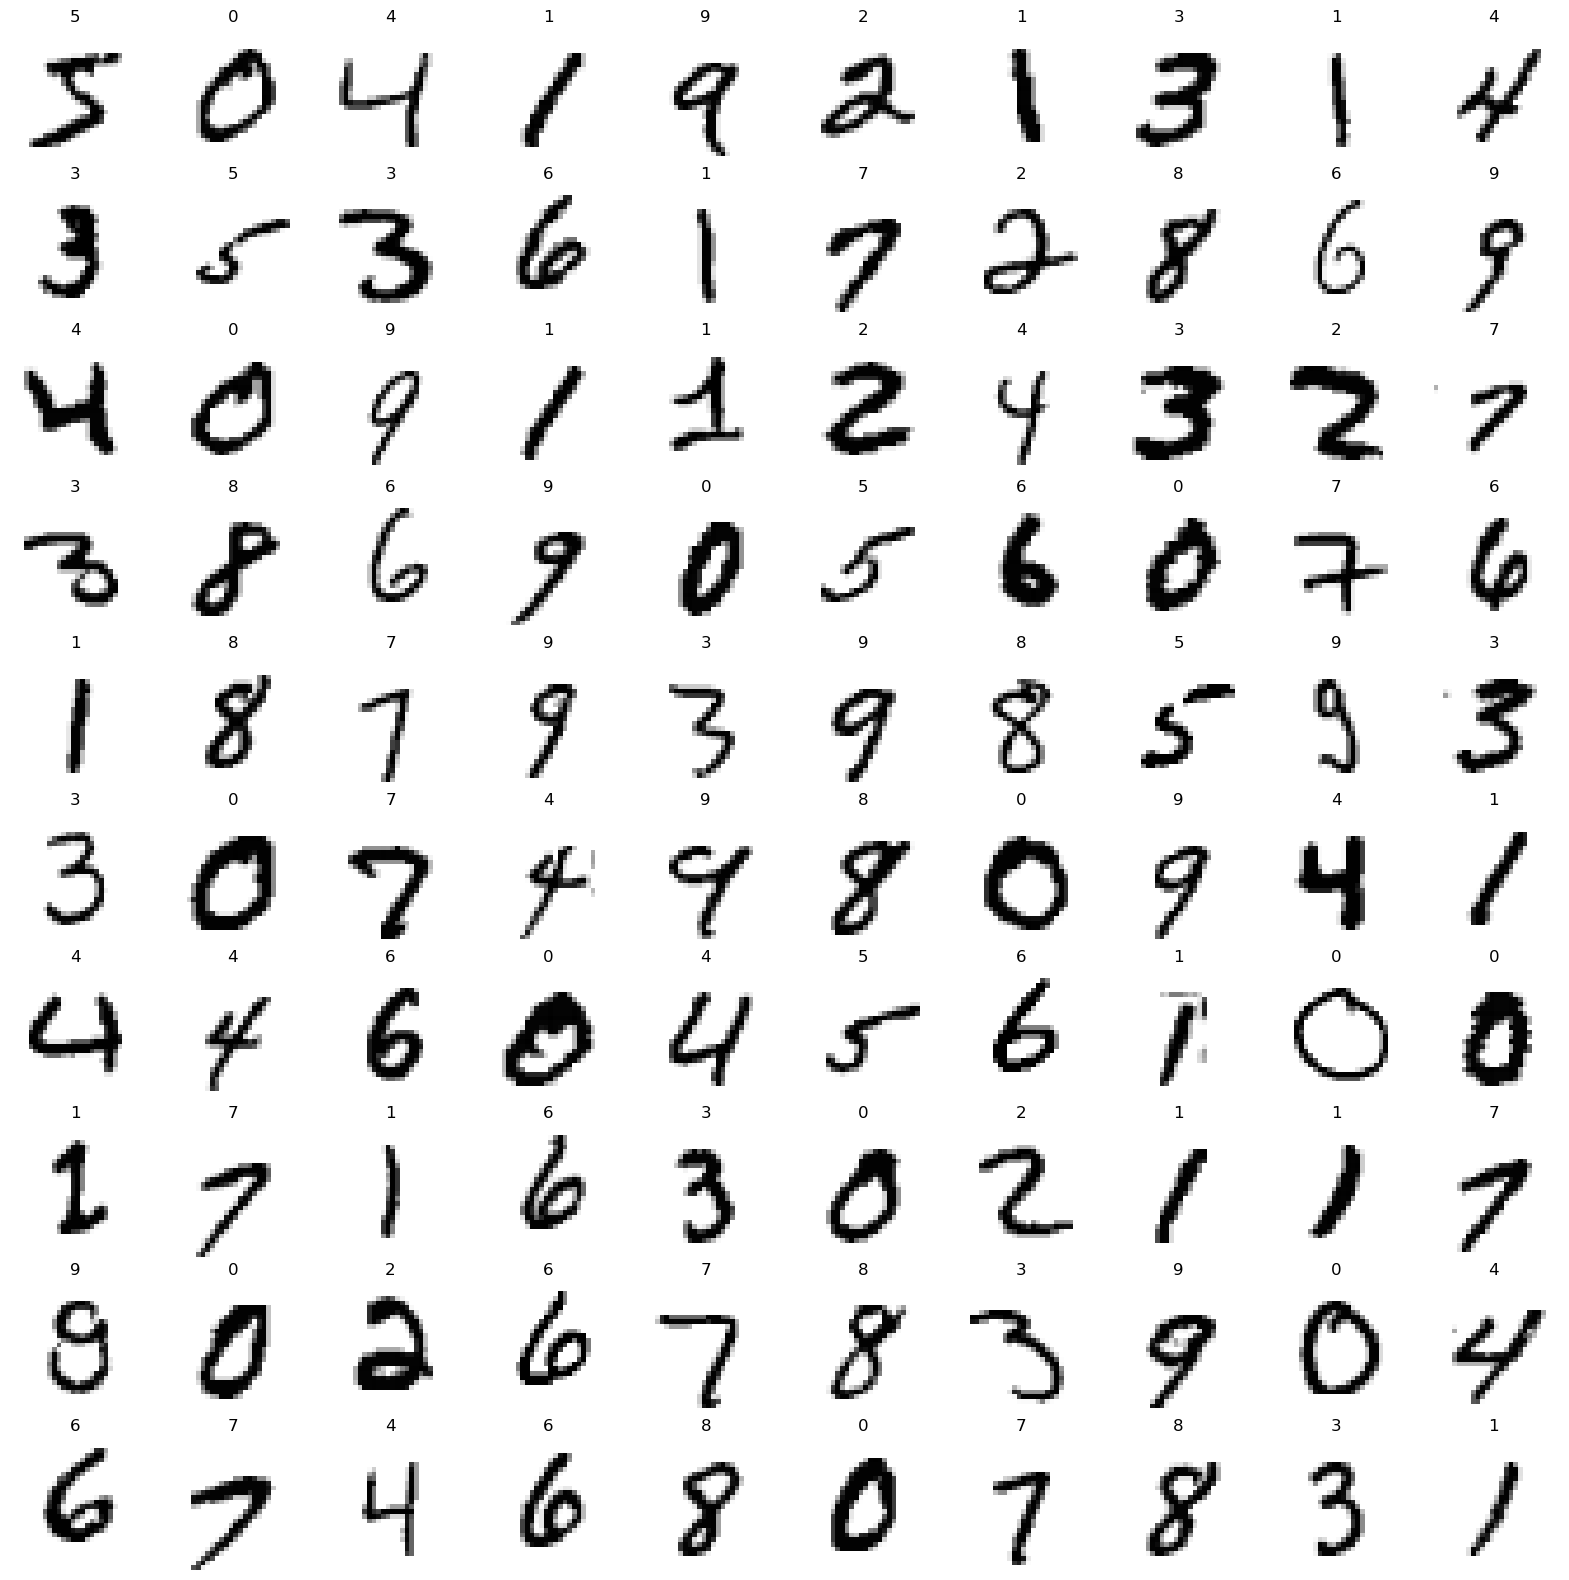

In [91]:
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(-Xtrain[i, :].reshape(28, 28), cmap='gray')
    plt.title(Ttrain[i, 0])
    plt.axis('off');

Okay.  We are ready to try to classify, right?

First we should check the proportions of each digit in the given data partitions.

In [92]:
classes = np.arange(10)
(Ttrain == classes).shape

(50000, 10)

In [93]:
(Ttrain == classes).sum(axis=0)

array([4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988])

In [94]:
(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]

array([0.09864, 0.11356, 0.09936, 0.10202, 0.09718, 0.09012, 0.09902,
       0.1035 , 0.09684, 0.09976])

In [95]:
['Ttrain', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]]

['Ttrain',
 0.09864,
 0.11356,
 0.09936,
 0.10202,
 0.09718,
 0.09012,
 0.09902,
 0.1035,
 0.09684,
 0.09976]

In [96]:
import pandas

result = []
result.append(['Train', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]])
result.append(['Tval', *(Tval == classes).sum(axis=0) / Tval.shape[0]])
result.append(['Ttest', *(Ttest == classes).sum(axis=0) / Ttest.shape[0]])
pandas.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,10
0,Train,0.09864,0.11356,0.09936,0.10202,0.09718,0.09012,0.09902,0.1035,0.09684,0.09976
1,Tval,0.09910,0.10640,0.09900,0.10300,0.09830,0.09150,0.09670,0.1090,0.10090,0.09610
2,Ttest,0.09800,0.11350,0.10320,0.10100,0.09820,0.08920,0.09580,0.1028,0.09740,0.10090


All very close to 0.1. Super.

Time for our first experiment.  Let's train a small neural net with 5 hidden units in one layer for a small number of epochs using Adam.

In [97]:
n_epochs = 100
learning_rate = 0.01

np.random.seed(142)

nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)

Adam: Epoch 10 Error=0.82887
Adam: Epoch 20 Error=0.85170
Adam: Epoch 30 Error=0.87229
Adam: Epoch 40 Error=0.88913
Adam: Epoch 50 Error=0.90202
Adam: Epoch 60 Error=0.91179
Adam: Epoch 70 Error=0.91932
Adam: Epoch 80 Error=0.92541
Adam: Epoch 90 Error=0.93041
Adam: Epoch 100 Error=0.93447


NeuralNetworkClassifier(784, [5], 10, 'tanh')

In [98]:
print(nnet)  # uses the __str__ method

NeuralNetworkClassifier(784, [5], 10, 'tanh') trained for 100 epochs, final training error 0.9345


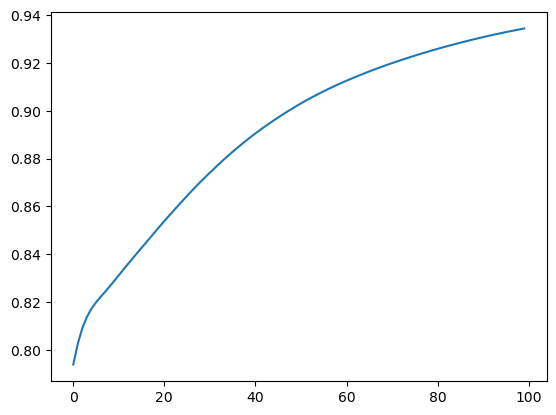

In [99]:
plt.plot(nnet.error_trace);

Now it is time for you to run some longer experiments.  You must write the code to do the following steps:

1. For each of at least five different hidden layer structures

    1. Train a network for 500 epochs.
    1. Collect percent of samples correctly classified in the given train, validate, and test partitions.

2. Create a `pandas.DataFrame` with these results and with column headings `('Hidden Layers', 'Train', 'Validate', 'Test', 'Time')` where `'Time'` is the number of seconds required to train each network.

3. Retrain a network using the best hidden layer structure, judged by the percent correct on the validation set.
4. Use this network to find several images in the test set for which the network's probability of the correct class is the closest to zero, meaning images for which your network does the worst.  Draw these images and discuss why your network might not be doing well for those images.

In [100]:
from IPython.display import display, clear_output  # for the following animation.
import matplotlib.animation as animation
from pdb import set_trace
import time

def run_experiment(Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,n_epochs_choices,n_hidden_units_per_layer_choices):
    learning_rate =0.01
    results=[]
    Classes = np.unique(Ttrain)
    fig = plt.figure(figsize=(8, 8))
    val_graph=[]
#     Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X,T,n_folds)
    for epoch in n_epochs_choices:
#         print(epoch)
        i=0     
        for hidden_units in n_hidden_units_per_layer_choices:
            Time =[]
#             nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))

            nnet = NeuralNetworkClassifier(Xtrain.shape[1], hidden_units,len(Classes))
            start_time = time.time()
            nnet.train(Xtrain, Ttrain, epoch, learning_rate, method='adam',verbose=True)
            Time_for_train = time.time() - start_time

            C_test, Y_test = nnet.use(Xtest)
            C_train, Y_train = nnet.use(Xtrain)
            C_val, Y_val = nnet.use(Xval)

            test_p   = np.mean(C_test == Ttest) * 100
            train_p  = np.mean(C_train == Ttrain) * 100
            val_p    = np.mean(C_val == Tval) * 100
            val_graph.append(val_p)
            results.append([hidden_units,
                            train_p,
                            val_p,
                            test_p,
                            Time_for_train])
            df = pandas.DataFrame(results, columns=('nh', 'Train',
                                                'Validate', 'Test','Time'))
            fig.clf()

            # In second panel plot the weights versus the epoch number
            # plt.subplot(2, 2, i+1)
            # set_trace()
            xs = range(df.shape[0])
            plt.plot(xs,val_graph,'o-')

            xticks = df[['nh']].apply(lambda x: f'{x[0]}', axis=1) # converting to strings
            plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
            plt.xlabel('Epochs, Architecture')
            plt.xlim(0, len(n_hidden_units_per_layer_choices))
            plt.ylim(30, 100)
            plt.legend(('$Validation$', '$w_1$'))
            clear_output(wait=True)
            display(fig)
    
        
 
    return df

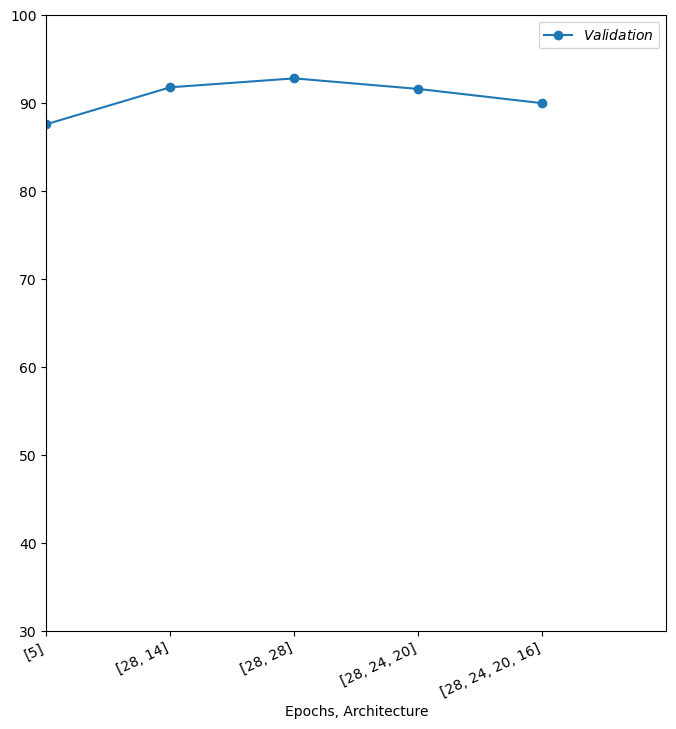

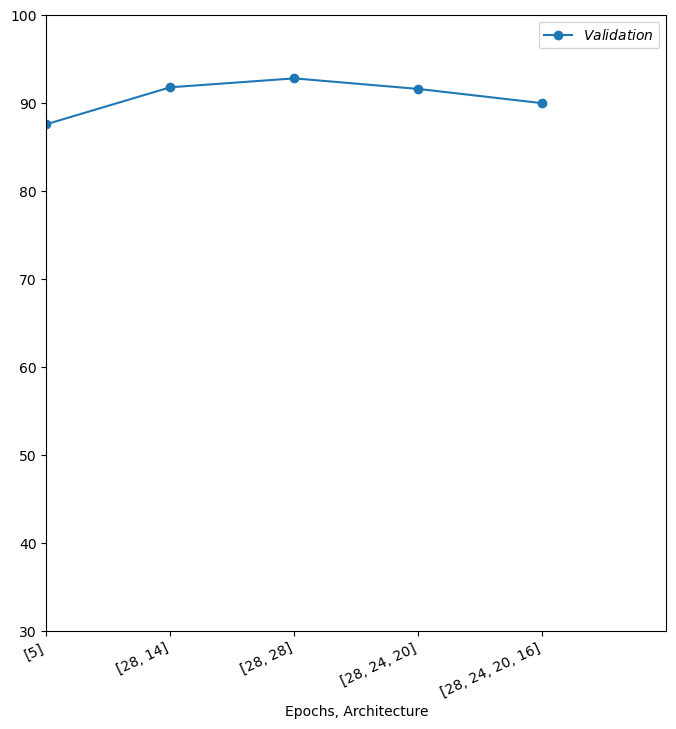

In [101]:
result_df = run_experiment( Xtrain, Ttrain, Xval, Tval, Xtest, Ttest,
                           n_epochs_choices=[500],
                           n_hidden_units_per_layer_choices=[[5], [28,14],[28,28],[28,24,20],[28,24,20,16]])

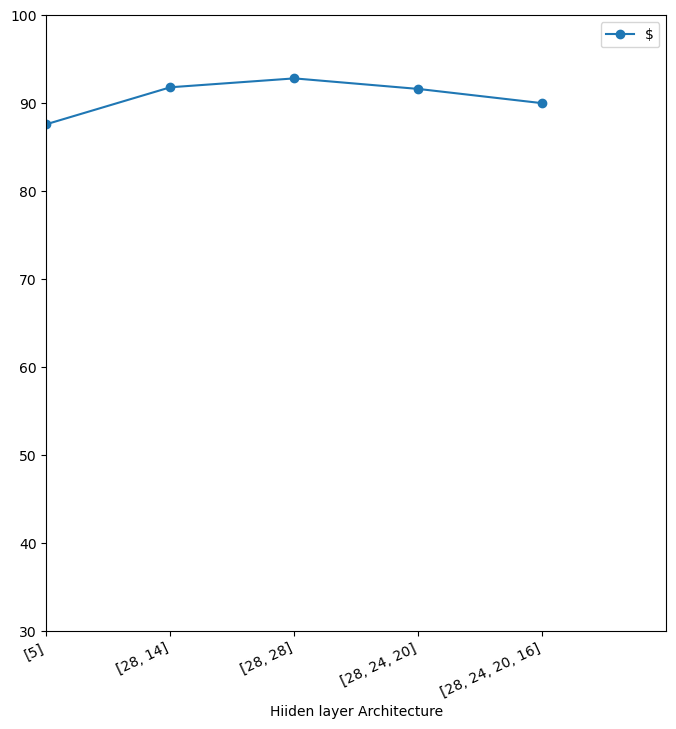

In [102]:
                        
fig = plt.figure(figsize=(8, 8))
fig.clf()

xs = range(result_df.shape[0])
plt.plot(xs,result_df['Validate'],'o-')

xticks = result_df[['nh']].apply(lambda x: f'{x[0]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Hiiden layer Architecture')
plt.xlim(0, len(result_df[['nh']]))
plt.ylim(30, 100)
plt.legend(('$Validation$'))

In [103]:
result_df

,nh,Train,Validate,Test,Time
0,[5],89.624,87.62,86.71,7471.008789
1,"[28, 14]",99.276,91.82,91.73,811.263884
2,"[28, 28]",99.682,92.83,92.44,307.278700
3,"[28, 24, 20]",99.504,91.63,91.48,4025.062598
4,"[28, 24, 20, 16]",99.066,90.01,89.00,331.238590


In [104]:
nnet = NeuralNetworkClassifier(Xtrain.shape[1], [28,28], len(classes))
nnet.train(Xtrain, Ttrain, 500, 0.01, method='adam', verbose=True)
Y_classes1, Y_probs1 = nnet.use(Xtest)

Adam: Epoch 50 Error=0.97435
Adam: Epoch 100 Error=0.98731
Adam: Epoch 150 Error=0.99182
Adam: Epoch 200 Error=0.99427
Adam: Epoch 250 Error=0.99572
Adam: Epoch 300 Error=0.99663
Adam: Epoch 350 Error=0.99729
Adam: Epoch 400 Error=0.99775
Adam: Epoch 450 Error=0.99808
Adam: Epoch 500 Error=0.99833


Number of images with predicted probability less than 0.001: 161
The Following Images were poorly predicted


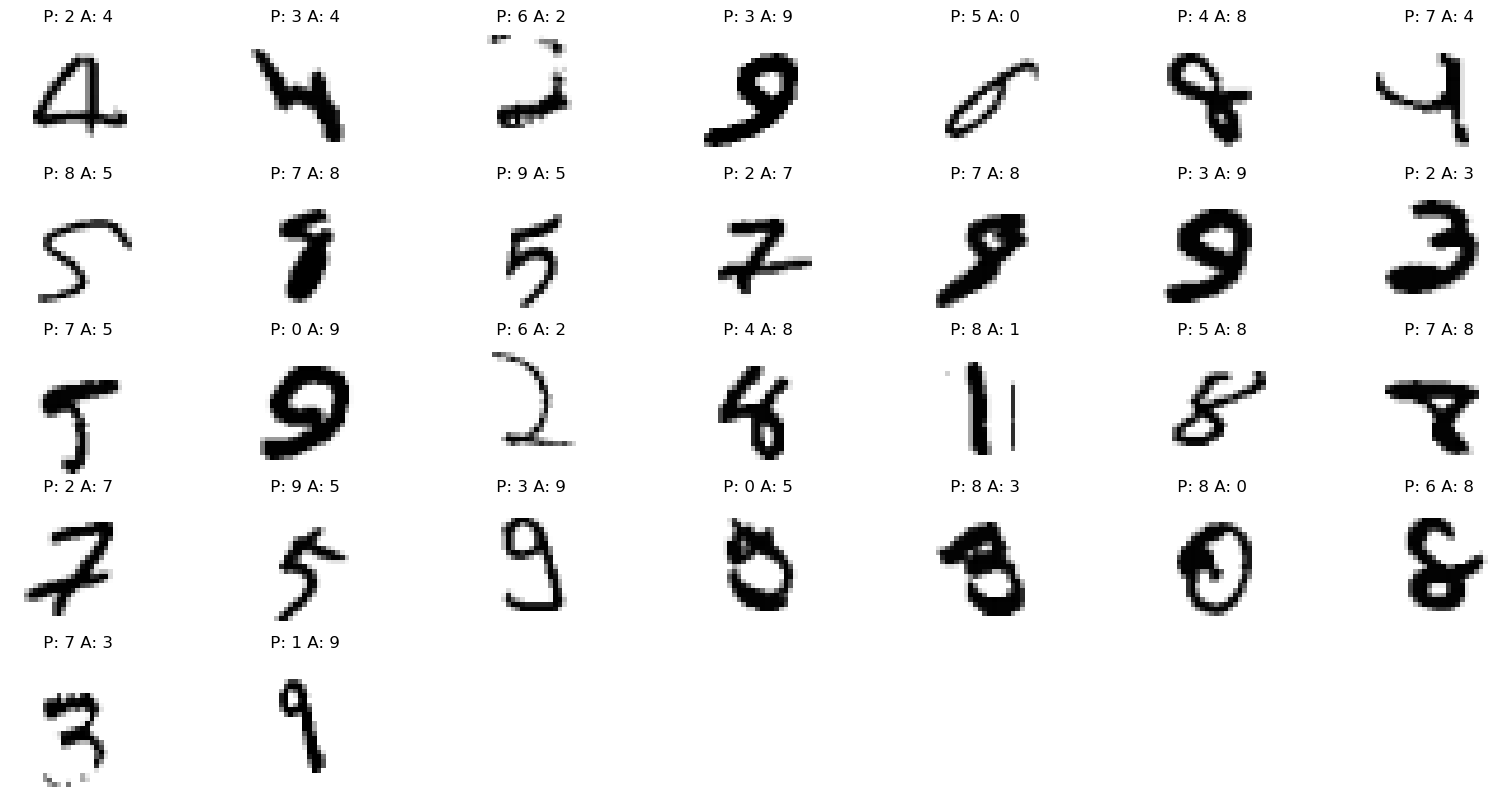

In [105]:
x=0.001
Cort_val = Y_probs1[range(10000), Ttest.reshape(-1)]
new_array = np.sort(Cort_val[Cort_val<x])
number = np.shape(new_array)[0]
print("Number of images with predicted probability less than %.3f" %x +": %d" %number)
print("The Following Images were poorly predicted")

plt.figure(figsize=(20, 20))
# 
for i in range(0,30):
    idx = np.where(Cort_val == new_array[i])
    idx = idx[0][0]
    # set_trace()
    plt.subplot(10, 7, i +1)
    plt.imshow(-Xtest[idx,:].reshape(28,28),cmap = 'gray') 
    # plt.imshow(-Xtrain[i, :].reshape(28, 28), cmap='gray')
    plt.title(" P: %d " % Y_classes1[idx,0] + "A: %d"% Ttest[idx])
    plt.axis('off');
    

## `confusion_matrix`

Now, write a function named `confusion_matrix` that returns a confusion matrix for any classification problem, returned as a `pandas.DataFrame` as shown in Lecture Notes 12.  It must require two arguments, the predicted classes for each sample and the true classes for each sample.  Here is an example.

In [106]:
def confusion_matrix(Y_classes, Actual):
    
    size = np.size(np.unique(Y_classes))
#     size = size +1c 
    Classes = np.unique(Y_classes)

    table = []
    for true_class in range(0, size):
        row = []
#         set_trace()
        for predicted_class in range(0, size):
#             set_trace()
            row.append(100 * np.mean(Y_classes[Actual == Classes[true_class]] == Classes[predicted_class]))
            # row.append(f'{100 * np.mean(Classes[Ttrain == true_class] == predicted_class):0.1f}')
        table.append(row)

    print(f'Accuracy {np.mean(Y_classes == Actual) * 100:.2f}') 
    
    conf_matrix = pandas.DataFrame(table, index=Classes, columns=Classes)
    conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f} %")
    # def confusion_matrix(Y_classes, Ttest)
    return conf_matrix

In [107]:
Y_classes1, Y_probs1 = nnet.use(Xtest)
Y_classes2, Y_probs2 = nnet.use(Xtrain)
Y_classes3, Y_probs3 = nnet.use(Xval)

print( "Testing Data Accuracy")
out_Test = confusion_matrix(Y_classes1, Ttest)
out_Test.style.background_gradient(cmap='Greens').format("{:.1f} %")

Testing Data Accuracy
Accuracy 92.34


,0,1,2,3,4,5,6,7,8,9
0,96.2 %,0.0 %,0.6 %,0.0 %,0.5 %,1.0 %,0.8 %,0.5 %,0.2 %,0.1 %
1,0.0 %,98.2 %,0.3 %,0.3 %,0.0 %,0.1 %,0.3 %,0.3 %,0.5 %,0.1 %
2,0.9 %,0.3 %,90.1 %,2.9 %,0.6 %,0.5 %,1.5 %,0.7 %,2.3 %,0.3 %
3,0.3 %,0.1 %,2.0 %,90.3 %,0.1 %,3.3 %,0.4 %,1.1 %,1.7 %,0.8 %
4,0.1 %,0.5 %,0.6 %,0.2 %,92.9 %,0.1 %,1.1 %,0.9 %,0.4 %,3.2 %
5,0.6 %,0.1 %,0.6 %,3.6 %,0.7 %,88.2 %,1.0 %,0.7 %,3.7 %,0.9 %
6,0.7 %,0.3 %,0.9 %,0.2 %,1.1 %,1.5 %,94.2 %,0.1 %,0.8 %,0.1 %
7,0.0 %,0.9 %,2.0 %,1.1 %,0.7 %,0.0 %,0.0 %,91.7 %,0.1 %,3.5 %
8,0.9 %,0.4 %,0.9 %,2.1 %,0.8 %,2.7 %,0.8 %,0.9 %,89.5 %,0.9 %
9,0.7 %,0.5 %,0.2 %,1.1 %,2.4 %,0.6 %,0.0 %,2.4 %,1.2 %,91.0 %


In [108]:
print( "Training Data Accuracy")

out_Train = confusion_matrix(Y_classes2, Ttrain)
out_Train.style.background_gradient(cmap='Greens').format("{:.1f} %")

Training Data Accuracy
Accuracy 99.73


,0,1,2,3,4,5,6,7,8,9
0,99.8 %,0.0 %,0.0 %,0.0 %,0.1 %,0.0 %,0.0 %,0.0 %,0.0 %,0.0 %
1,0.0 %,99.9 %,0.0 %,0.0 %,0.0 %,0.1 %,0.0 %,0.0 %,0.0 %,0.0 %
2,0.0 %,0.0 %,99.7 %,0.0 %,0.0 %,0.0 %,0.1 %,0.1 %,0.1 %,0.0 %
3,0.0 %,0.0 %,0.1 %,99.5 %,0.0 %,0.1 %,0.0 %,0.1 %,0.1 %,0.1 %
4,0.0 %,0.0 %,0.0 %,0.0 %,99.8 %,0.0 %,0.1 %,0.0 %,0.0 %,0.1 %
5,0.0 %,0.1 %,0.0 %,0.1 %,0.0 %,99.7 %,0.0 %,0.0 %,0.0 %,0.0 %
6,0.1 %,0.0 %,0.0 %,0.0 %,0.1 %,0.0 %,99.8 %,0.0 %,0.0 %,0.0 %
7,0.0 %,0.0 %,0.1 %,0.1 %,0.0 %,0.0 %,0.0 %,99.7 %,0.0 %,0.1 %
8,0.0 %,0.0 %,0.1 %,0.1 %,0.0 %,0.0 %,0.0 %,0.0 %,99.8 %,0.0 %
9,0.0 %,0.0 %,0.0 %,0.0 %,0.1 %,0.0 %,0.0 %,0.1 %,0.1 %,99.7 %


In [109]:
print( "Validation Data Accuracy")
out_Valid = confusion_matrix(Y_classes3, Tval)
out_Valid.style.background_gradient(cmap='Greens').format("{:.1f} %")

Validation Data Accuracy
Accuracy 93.11


,0,1,2,3,4,5,6,7,8,9
0,96.3 %,0.0 %,1.2 %,0.1 %,0.6 %,0.4 %,0.6 %,0.3 %,0.5 %,0.0 %
1,0.0 %,97.4 %,0.4 %,0.4 %,0.1 %,0.6 %,0.5 %,0.2 %,0.4 %,0.2 %
2,0.5 %,0.8 %,91.6 %,2.0 %,0.6 %,0.3 %,1.2 %,1.4 %,1.3 %,0.2 %
3,0.6 %,0.2 %,1.5 %,91.8 %,0.2 %,2.3 %,0.3 %,0.4 %,2.1 %,0.6 %
4,0.2 %,0.7 %,0.2 %,0.0 %,94.4 %,0.1 %,0.3 %,0.7 %,0.7 %,2.6 %
5,0.3 %,0.3 %,0.9 %,3.7 %,1.3 %,87.7 %,2.0 %,0.2 %,2.6 %,1.0 %
6,0.3 %,0.3 %,1.1 %,0.1 %,0.5 %,0.6 %,96.4 %,0.0 %,0.6 %,0.0 %
7,0.2 %,0.6 %,0.5 %,0.7 %,0.2 %,0.2 %,0.0 %,96.0 %,0.1 %,1.7 %
8,0.4 %,1.0 %,1.3 %,1.8 %,0.7 %,2.8 %,0.7 %,0.3 %,89.5 %,1.6 %
9,0.5 %,0.2 %,0.5 %,0.8 %,2.7 %,0.6 %,0.0 %,4.1 %,1.4 %,89.2 %


In [110]:
Y_classes, Y_probs = nnet.use(Xtest)
confusion_matrix(Y_classes, Ttest)

Accuracy 92.34


,0,1,2,3,4,5,6,7,8,9
0,96.224490,0.000000,0.612245,0.000000,0.510204,1.020408,0.816327,0.510204,0.204082,0.102041
1,0.000000,98.237885,0.264317,0.264317,0.000000,0.088106,0.264317,0.264317,0.528634,0.088106
2,0.872093,0.290698,90.116279,2.906977,0.581395,0.484496,1.453488,0.678295,2.325581,0.290698
3,0.297030,0.099010,1.980198,90.297030,0.099010,3.267327,0.396040,1.089109,1.683168,0.792079
4,0.101833,0.509165,0.610998,0.203666,92.871690,0.101833,1.120163,0.916497,0.407332,3.156823
5,0.560538,0.112108,0.560538,3.587444,0.672646,88.228700,1.008969,0.672646,3.699552,0.896861
6,0.730689,0.313152,0.939457,0.208768,1.148225,1.461378,94.154489,0.104384,0.835073,0.104384
7,0.000000,0.875486,2.042802,1.070039,0.680934,0.000000,0.000000,91.731518,0.097276,3.501946
8,0.924025,0.410678,0.924025,2.053388,0.821355,2.669405,0.821355,0.924025,89.527721,0.924025
9,0.693756,0.495540,0.198216,1.090188,2.378593,0.594648,0.000000,2.378593,1.189296,90.981169


<h3>"Discussion and Final Results"</h3>

<p>The model with the highest accuracy was achieved using an architecture consisting of two hidden layers with 28 units in each layer [28,28]. This model yielded an accuracy of approximately <b>92.34%</b> on the validation data and 93% on the testing data. As the number of hidden layers increased, the model's performance on the testing and validation data declined. For example, the architecture with [28,20,12] layers resulted in a training accuracy of 99.194% but a validation accuracy of 91.18% and a testing accuracy of 90.43%. A model with only one hidden layer and five units performed poorly, with testing, validation, and training accuracies of 87.84%, 86.32%, and 85.37%, respectively.
</p>
<p>
The confusion matrix revealed that the [28,28] model achieved a training accuracy of 99.64%. In the validation data, 3.1% of cases had the number 3 misclassified as 5 and vice versa. Additionally, 2.0% of digit 2 was identified as digit 3, which could be attributed to the slight similarities in their curves and various handwriting styles. Furthermore, 2.4% of cases had digit 9 mislabeled as 7 due to their resemblance.
</p>
<p>
By examining the test set images where the network's probability of the correct class was closest to zero, we can identify instances where the model performed poorly. These images, with their predicted output (P:) and actual label (A:), were displayed above. The poorly-drawn and visually confusing nature of these images made them difficult to classify even for the human eye. For instance, a number 7 was mislabeled as digit 2 because of its drawing style. Overall, the model accurately predicted the numbers in most cases, with a few exceptions potentially resulting from the quality of the training data.
    </p>

## Grading and Check-In

You will receive 50 points for correct code, and 50 points for other results and your discussions.  As before, you can test your code against the grading script yourself by downloading [A4grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A4grader.zip) and extracting `A4grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the in the following cell to see an example grading run.  Submit assignments **through Canvas** following the pattern of the previous assignments. *Do not send your file to the instructor/TA via email or any other medium!*

In [111]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named ' karra-A4.ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook  karra-A4.ipynb to script


Removing all statements that are not function or class defs or import statements.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.forward_pass.__func__ == nn_class.forward_pass.__func__


--- 5/5 points.  Function NeuralNetwork.forward_pass is correctly not overridden in NeuralNetworkClassifier.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.train.__func__ != nn_class.train.__func__


--- 5/5 points.  Function NeuralNetwork.train is correctly overridden in NeuralNetworkClassifier.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.use.__func__ != nn_class.use.__func__


--- 5/5 points.  Function NeuralNetwork.use is correctly overridden in NeuralNetworkClassifier.

Testing

    nn_class = NeuralNetworkClassifier(1, [5], 5)
    result = nn_class.makeIndicatorVars(np.arange(5).reshape(-1, 1))



--- 5/5 poi

## Extra Credit
Earn 5 extra credit point on this assignment by doing the following.

1. Combine the train, validate, and test partitions loaded from the MNIST data file into two matrices, `X` and `T`. 
2. Using `adam` , `relu` and just one value of `learning_rate` and `n_epochs`, compare several hidden layer architectures. Do so by applying our `generate_k_fold_cross_validation_sets` function as defined in Lecture Notes 10 which forms stratified partitioning, for use in classification problems, to your `X` and `T` matrices using `n_fold` of 3.
3. Show results and discuss which architectures you find works the best, and how you determined this.

In [112]:
# 1 Combininga Train Test and Validation data from MNIST

X = np.concatenate((Xtrain,Xval,Xtest), axis=0)
T = np.concatenate((Ttrain,Tval,Ttest) ,axis=0)
np.shape(T),np.shape(X)

((70000, 1), (70000, 784))

In [113]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

In [114]:
from IPython.display import display, clear_output  # for the following animation.

def run_experiment_k_folds(X,T,epoch,n_hidden_units_per_layer_choices,method ='adam'):
    learning_rate =0.01
    results=[]
    Classes = np.unique(T)
    val_graph =[]
    fig = plt.figure(figsize=(8, 8))

    Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = next(generate_k_fold_cross_validation_sets(X, T, 3))
      
    for hidden_units in n_hidden_units_per_layer_choices:
        Time =[]
#             nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))

        nnet = NeuralNetworkClassifier(Xtrain.shape[1], hidden_units,len(Classes),activation_function='relu')
        start_time = time.time()
        nnet.train(Xtrain, Ttrain, epoch, learning_rate, method='adam',verbose=True)
        Time_for_train = time.time() - start_time

        C_test, Y_test = nnet.use(Xtest)
        C_train, Y_train = nnet.use(Xtrain)
        C_val, Y_val = nnet.use(Xval)

        test_p   = np.mean(C_test == Ttest) * 100
        train_p  = np.mean(C_train == Ttrain) * 100
        val_p    = np.mean(C_val == Tval) * 100
        val_graph.append(val_p)
        fig.clf()

        # In second panel plot the weights versus the epoch number
        # plt.subplot(2, 2, i+1)
        # set_trace()
        plt.plot(val_graph,'o-')
        plt.xlabel('Updates')
        plt.xlim(0, len(n_hidden_units_per_layer_choices))
        plt.ylim(30, 100)
        plt.legend(('$w_0$'))
        clear_output(wait=True)
        display(fig)
        results.append([hidden_units,
                        train_p,
                        val_p,
                        test_p,
                        Time_for_train])
        df = pandas.DataFrame(results, columns=('nh','Train',
                                            'Validate', 'Test','Time'))
        print(df)  
    
    return df

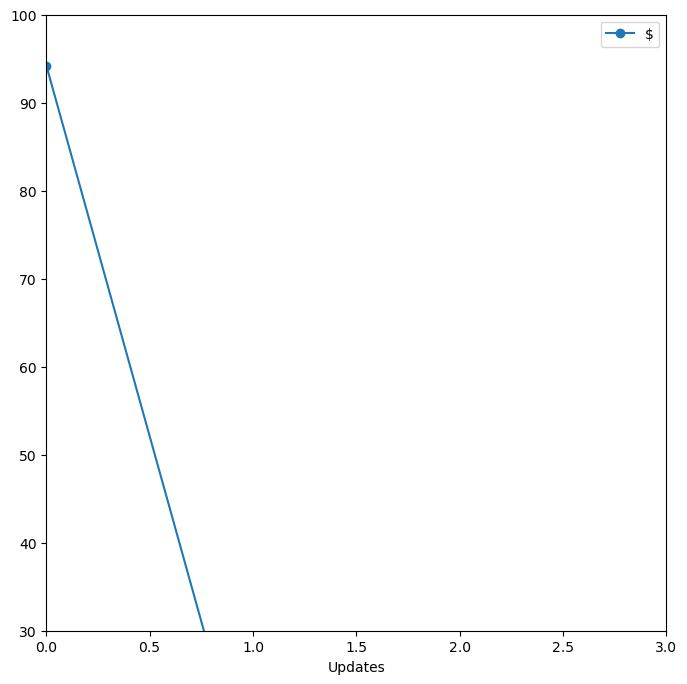

                 nh      Train   Validate       Test        Time
0          [28, 28]  99.991429  94.222775  94.244203  144.564563
1      [28, 24, 20]   9.882575   9.977285   9.724425  144.167418
2  [28, 24, 20, 16]   9.882575   9.977285   9.724425  146.347041


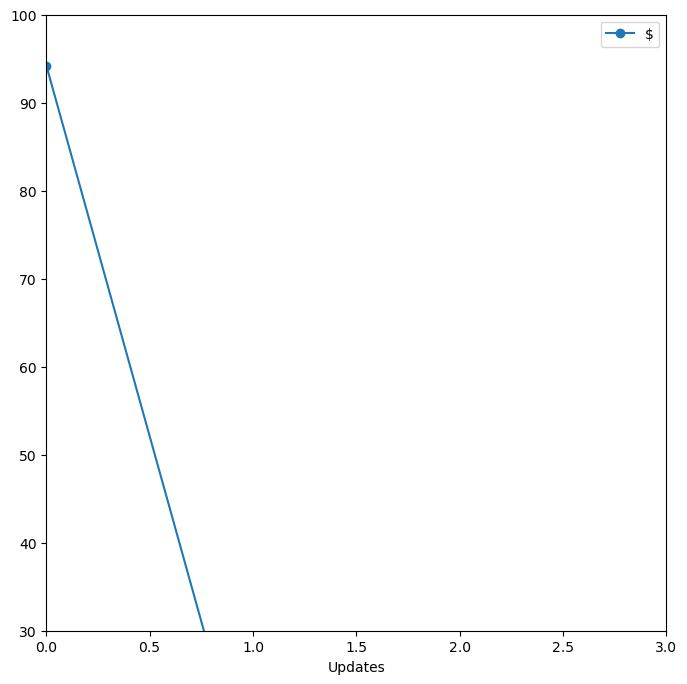

In [115]:
result_df_ec = run_experiment_k_folds( X,T,
                           epoch=500,
                           n_hidden_units_per_layer_choices=[[28,28],[28,24,20],[28,24,20,16]]) 

<h3>"comments"</h3>

<p>Now that we have joined all the train test and validation data and are shuffling the data we see that the model with the same configuration has performed better compared to when not suffling the data. The Configuration with 2 hidden layes [28,28] performed better than the other configurations. The Model had an accuracy of 94.48 on the validation data and 94.424% on the test data and 99.99% on the traning set. 
    </p>